Importaciones

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import requests
from sklearn.dummy import DummyClassifier
from plotnine import *
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import gradio as gr

c:\Users\pepepez\Desktop\carpeta de carpetas\Uni y tal\UniDataS\FinalDataScience\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


API Token

In [2]:
api = "d073f379a0e94969beb4956bda52ef0f"
headers = {"X-Auth-Token": api}

Obtengo todos los datos

In [3]:
df = pd.DataFrame()
for year in range(2022, 2025):
    url = f'https://api.football-data.org/v4/competitions/PD/matches?season={year}'

    response = requests.get(url, headers=headers)
    data = response.json()

    matches = data["matches"]
    df_season = pd.DataFrame(matches)
    df = pd.concat([df, df_season], ignore_index=True)

Formateando columna 'season'

In [4]:
df['startDate'] = df['season'].apply(lambda x: x['startDate'])
df['endDate'] = df['season'].apply(lambda x: x['endDate'])

df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])
df['season'] = df['startDate'].dt.year.astype(str) + '/' + df['endDate'].dt.year.astype(str).str[-2:]

Formateando columnas 'awayTeam' y 'homeTeam'

In [5]:
df['homeTeam'] = df['homeTeam'].apply(lambda x: x['name'])
df['awayTeam'] = df['awayTeam'].apply(lambda x: x['name'])

Formateando columna 'score' y añadiendo columnas de goles de local y visitante, resultado media parte y resultado final

In [6]:
df['homeGoalsFullTime'] = df['score'].apply(lambda x: x['fullTime']).apply(lambda x: x["home"])
df['awayGoalsFullTime'] = df['score'].apply(lambda x: x['fullTime']).apply(lambda x: x["away"])

df['homeGoalsHalfTime'] = df['score'].apply(lambda x: x['halfTime']).apply(lambda x: x["home"])
df['awayGoalsHalfTime'] = df['score'].apply(lambda x: x['halfTime']).apply(lambda x: x["away"])

Formateando columna 'referees'

In [7]:
df["referees"] = df['referees'].apply(lambda x: x[0]['name'] if isinstance(x, list) and len(x) > 0 else None)

Eliminando columnas irrelevantes

In [8]:
df = df.drop(["startDate", "endDate", "competition", "area", "odds", "id", "utcDate", "stage", "group", "lastUpdated", "score"], axis=1)

Feature Engineering

In [9]:
teams = df["homeTeam"].unique()
seasons = df["season"].unique()

for team in teams:
    total_matches = df.loc[(df["awayTeam"] == team) | (df["homeTeam"] == team)]
    total_matches_finished = total_matches.loc[total_matches["status"] == "FINISHED"]
    total_matches_home = total_matches_finished.loc[total_matches_finished["homeTeam"] == team]
    total_matches_away = total_matches_finished.loc[total_matches_finished["awayTeam"] == team]
    total_matches_finished_len = len(total_matches_finished)
    wins = ((total_matches_finished["homeTeam"] == team) & (total_matches_finished["homeGoalsFullTime"] > total_matches_finished["awayGoalsFullTime"])).sum() + \
           ((total_matches_finished["awayTeam"] == team) & (total_matches_finished["awayGoalsFullTime"] > total_matches_finished["homeGoalsFullTime"])).sum()

    draws = (total_matches_finished["homeGoalsFullTime"] == total_matches_finished["awayGoalsFullTime"]).sum()

    losses = ((total_matches_finished["homeTeam"] == team) & (total_matches_finished["homeGoalsFullTime"] < total_matches_finished["awayGoalsFullTime"])).sum() + \
             ((total_matches_finished["awayTeam"] == team) & (total_matches_finished["awayGoalsFullTime"] < total_matches_finished["homeGoalsFullTime"])).sum()

    df.loc[df["homeTeam"] == team, "homeTeamWins"] = wins
    df.loc[df["homeTeam"] == team, "homeTeamDraws"] = draws
    df.loc[df["homeTeam"] == team, "homeTeamLosses"] = losses

    df.loc[df["awayTeam"] == team, "awayTeamWins"] = wins
    df.loc[df["awayTeam"] == team, "awayTeamDraws"] = draws
    df.loc[df["awayTeam"] == team, "awayTeamLosses"] = losses
    
    total_away_team_goals = df.loc[(df["awayTeam"] == team)]["awayGoalsFullTime"].sum()
    total_home_team_goals = df.loc[(df["homeTeam"] == team)]["homeGoalsFullTime"].sum()
    total_goals = total_away_team_goals + total_home_team_goals
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoals"] = total_goals
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoals"] = total_goals
    df.loc[df["homeTeam"] == team, "homeTeamGoalRatio"] = total_goals / total_matches_finished_len
    df.loc[df["awayTeam"] == team, "awayTeamGoalRatio"] = total_goals / total_matches_finished_len
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoalsAtHome"] = total_home_team_goals
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoalsAway"] = total_away_team_goals
    df.loc[df["homeTeam"] == team, "homeTeamGoalRatioAtHome"] = total_home_team_goals / len(total_matches_home)
    df.loc[df["awayTeam"] == team, "awayTeamGoalRatioAway"] = total_away_team_goals / len(total_matches_away)
    total_home_team_goals_conceded = df.loc[df["homeTeam"] == team]["awayGoalsFullTime"].sum()
    total_away_team_goals_conceded = df.loc[df["awayTeam"] == team]["homeGoalsFullTime"].sum()
    total_goals_conceded = total_away_team_goals_conceded + total_home_team_goals_conceded
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoalsConceded"] = total_goals_conceded
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoalsConceded"] = total_goals_conceded
    df.loc[df["homeTeam"] == team, "homeTeamGoalConcededRatio"] = total_goals_conceded / total_matches_finished_len
    df.loc[df["awayTeam"] == team, "awayTeamGoalConcededRatio"] = total_goals_conceded / total_matches_finished_len
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoalsConcededAtHome"] = total_home_team_goals_conceded
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoalsConcededAway"] = total_away_team_goals_conceded
    df.loc[df["homeTeam"] == team, "homeTeamGoalConcededRatioAtHome"] = total_home_team_goals_conceded / len(total_matches_home)
    df.loc[df["awayTeam"] == team, "awayTeamGoalConcededRatioAway"] = total_away_team_goals_conceded / len(total_matches_away)

    for season in seasons:
        total_matches_finished_per_season = total_matches_finished.loc[total_matches_finished["season"] == season]
        total_matches_finished_per_season_len = len(total_matches_finished_per_season)
        total_matches_home_per_season = total_matches_finished_per_season.loc[total_matches_finished_per_season["homeTeam"] == team]
        total_matches_away_per_season = total_matches_finished_per_season.loc[total_matches_finished_per_season["awayTeam"] == team]
        total_home_team_goals_per_season = df.loc[(df["homeTeam"] == team) & (df["season"] == season)]["homeGoalsFullTime"].sum()
        total_away_team_goals_per_season = df.loc[(df["awayTeam"] == team) & (df["season"] == season)]["awayGoalsFullTime"].sum()
        total_home_team_goals_conceded_per_season = df.loc[(df["homeTeam"] == team) & (df["season"] == season)]["awayGoalsFullTime"].sum()
        total_away_team_goals_conceded_per_season = df.loc[(df["awayTeam"] == team) & (df["season"] == season)]["homeGoalsFullTime"].sum()
        total_goals_per_season = total_home_team_goals_per_season + total_away_team_goals_per_season
        total_goals_conceded_per_season = total_home_team_goals_conceded_per_season + total_away_team_goals_conceded_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "totalHomeTeamGoalsperSeason"] = total_goals_per_season
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "totalAwayTeamGoalsperSeason"] = total_goals_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "homeTeamGoalRatioperSeason"] = total_goals_per_season / total_matches_finished_per_season_len
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "awayTeamGoalRatioperSeason"] = total_goals_per_season / total_matches_finished_per_season_len
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "totalHomeTeamGoalsAtHomeperSeason"] = total_home_team_goals_per_season
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "totalAwayTeamGoalsAwayperSeason"] = total_away_team_goals_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "homeTeamGoalRatioAtHome"] = total_home_team_goals / len(total_matches_home_per_season)
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "awayTeamGoalRatioAway"] = total_away_team_goals / len(total_matches_away_per_season)
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "totalHomeTeamGoalsConcededperSeason"] = total_goals_conceded_per_season
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "totalAwayTeamGoalsConcededperSeason"] = total_goals_conceded_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "homeTeamGoalConcededRatioperSeason"] = total_goals_conceded_per_season / total_matches_finished_per_season_len
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "awayTeamGoalConcededRatioperSeason"] = total_goals_conceded_per_season / total_matches_finished_per_season_len
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "totalHomeTeamGoalsConcededAtHomeperSeason"] = total_home_team_goals_per_season
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "totalAwayTeamGoalsConcededAwayperSeason"] = total_away_team_goals_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "homeTeamGoalConcededRatioAtHome"] = total_home_team_goals_conceded_per_season / len(total_matches_home_per_season)
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "awayTeamGoalConcededRatioAway"] = total_away_team_goals_conceded_per_season / len(total_matches_away_per_season)

C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:62: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:63: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:66: RuntimeWarning: divide by zero encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:67: RuntimeWarning: divide by zero encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:70: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:71: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:74: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\pepepez\AppData\Local\Temp\ipykernel_29860\3168769328.py:75: RuntimeWarning: invalid v

Preprocesando

In [10]:
df_train = df.loc[df["status"] == "FINISHED"].loc[:, df.columns.drop(["awayGoalsHalfTime", "homeGoalsHalfTime", "season", "matchday", "status", "referees", "homeTeam", "awayTeam"])]
df_train.loc[df_train["homeGoalsFullTime"] > df_train["awayGoalsFullTime"], "winner"] = "WINNER_HOME"
df_train.loc[df_train["homeGoalsFullTime"] < df_train["awayGoalsFullTime"], "winner"] = "WINNER_AWAY"
df_train.loc[df_train["homeGoalsFullTime"] == df_train["awayGoalsFullTime"], "winner"] = "DRAW"
df_train = df_train.drop(columns=["homeGoalsFullTime", "awayGoalsFullTime"])
df_test = df.loc[df["status"] != "FINISHED"].loc[:, df.columns.drop(["awayGoalsHalfTime", "homeGoalsHalfTime", "homeGoalsFullTime", "awayGoalsFullTime", "season", "matchday", "status", "referees", "awayTeam", "homeTeam"])]

In [11]:
home_teams_test = df.loc[df["status"] != "FINISHED"]["homeTeam"]
away_teams_test = df.loc[df["status"] != "FINISHED"]["awayTeam"]

In [12]:
y = df_train["winner"]
x = df_train.drop(columns=["winner"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

EDA

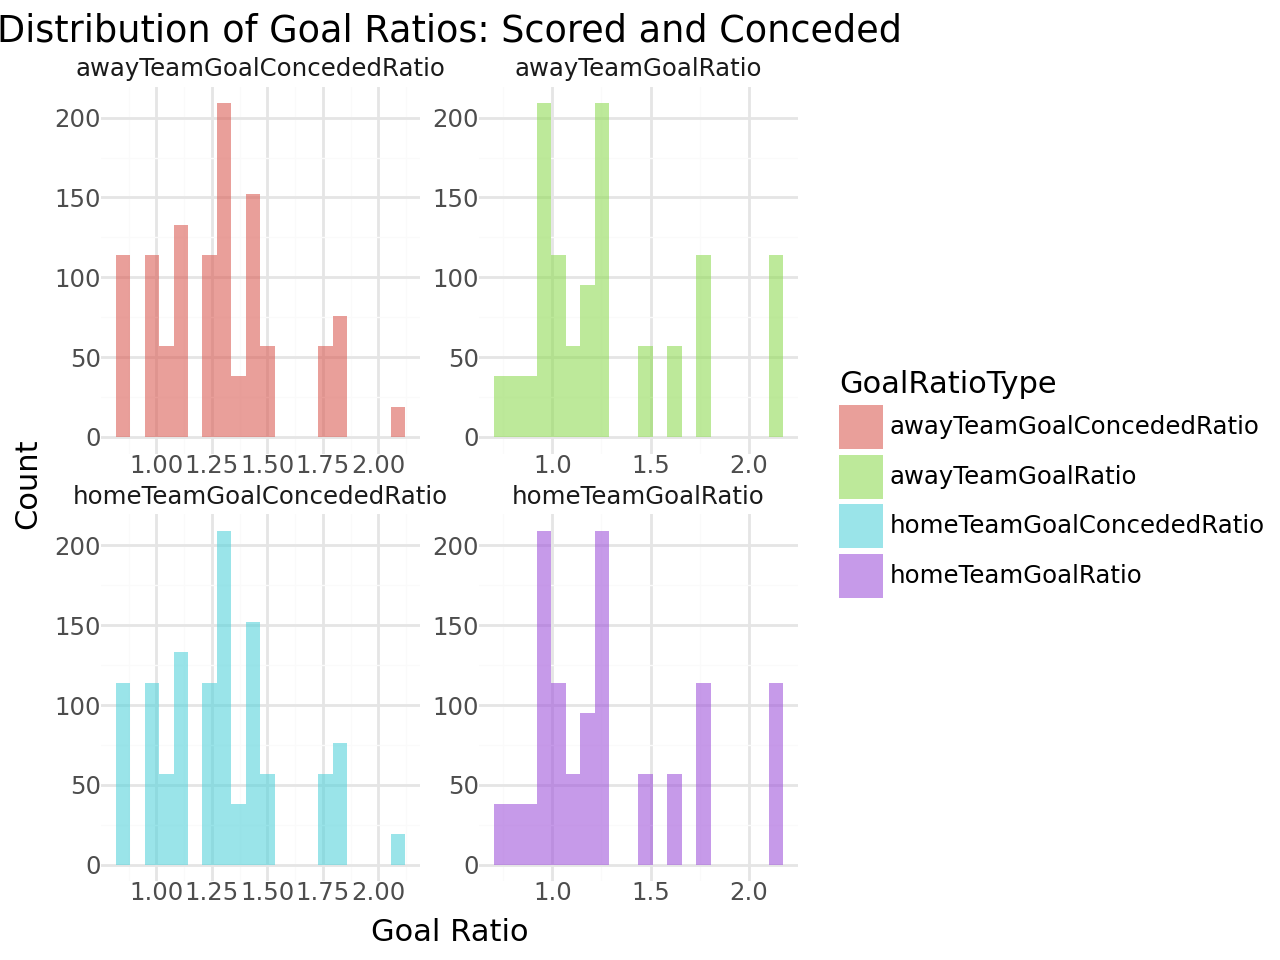

In [13]:
columns_to_plot = ['homeTeamGoalRatio', 'awayTeamGoalRatio', 'homeTeamGoalConcededRatio', 'awayTeamGoalConcededRatio']
df_melted = df.melt(value_vars=columns_to_plot, var_name='GoalRatioType', value_name='Ratio')
ggplot(df_melted, aes(x='Ratio', fill='GoalRatioType')) + geom_histogram(alpha=0.6, bins=20, position='identity') + facet_wrap('~GoalRatioType', scales='free') + labs(title='Distribution of Goal Ratios: Scored and Conceded', x='Goal Ratio', y='Count') + theme_minimal()


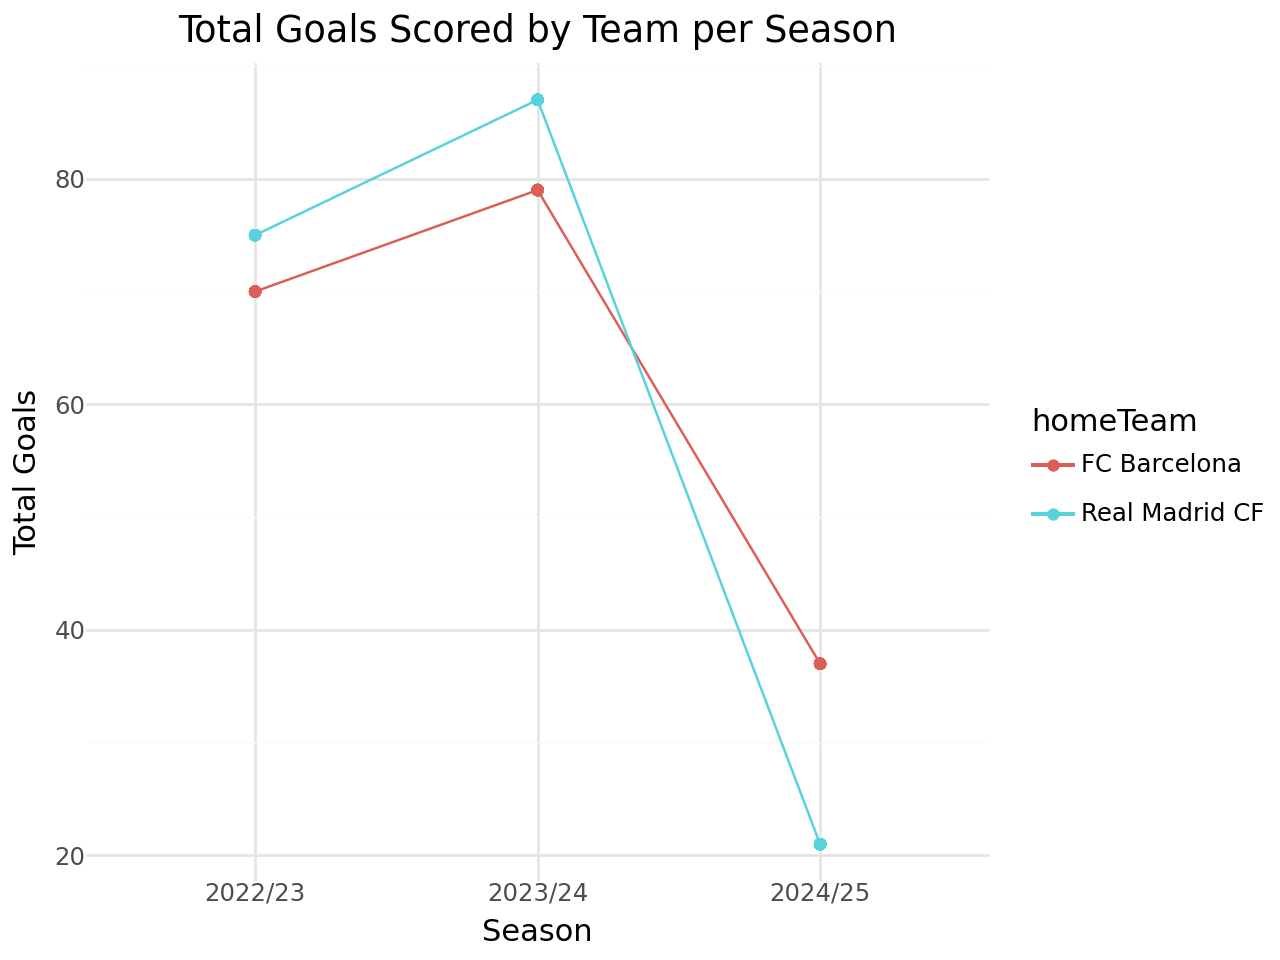

In [14]:
rm_fcb_comparison = df.loc[(df["homeTeam"] == "Real Madrid CF") | (df["homeTeam"] == "FC Barcelona")]
ggplot(rm_fcb_comparison, aes(x='season', y='totalHomeTeamGoalsperSeason', color='homeTeam', group='homeTeam')) + geom_point() + geom_line() + labs(title='Total Goals Scored by Team per Season', x='Season', y='Total Goals') + theme_minimal()

Entrenando el modelo

In [15]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

c:\Users\pepepez\Desktop\carpeta de carpetas\Uni y tal\UniDataS\FinalDataScience\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Guardar el modelo

In [16]:
with open('modelo.clf', 'wb') as file:
    pickle.dump(clf, file)

In [17]:
print("Confusion Matrix Training:\n", confusion_matrix(y_train, y_train_pred))
print("Confusion Matrix Test:\n", confusion_matrix(y_test, y_test_pred))

Confusion Matrix Training:
 [[ 40  36  82]
 [ 25  94  57]
 [ 18  43 213]]
Confusion Matrix Test:
 [[ 6 23 38]
 [10 41 19]
 [12 16 96]]


In [18]:
print("Classification Report Training:\n", classification_report(y_train, y_train_pred))
print("Classification Report Test:\n", classification_report(y_test, y_test_pred))

Classification Report Training:
               precision    recall  f1-score   support

        DRAW       0.48      0.25      0.33       158
 WINNER_AWAY       0.54      0.53      0.54       176
 WINNER_HOME       0.61      0.78      0.68       274

    accuracy                           0.57       608
   macro avg       0.54      0.52      0.52       608
weighted avg       0.56      0.57      0.55       608

Classification Report Test:
               precision    recall  f1-score   support

        DRAW       0.21      0.09      0.13        67
 WINNER_AWAY       0.51      0.59      0.55        70
 WINNER_HOME       0.63      0.77      0.69       124

    accuracy                           0.55       261
   macro avg       0.45      0.48      0.46       261
weighted avg       0.49      0.55      0.51       261



In [19]:
y_test_prediction = clf.predict(df_test)

In [20]:
df_test["winner"] = y_test_prediction
df_test["homeTeam"] = home_teams_test
df_test["awayTeam"] = away_teams_test

overview_test = df_test.loc[:, ["homeTeam", "awayTeam", "winner"]]
overview_test.loc[(overview_test["homeTeam"] == "Real Madrid CF") | (overview_test["awayTeam"] == "Real Madrid CF")].loc[overview_test["winner"] == "WINNER_HOME"]

,homeTeam,awayTeam,winner
881,Real Madrid CF,CA Osasuna,WINNER_HOME
906,Real Madrid CF,Getafe CF,WINNER_HOME
938,Real Madrid CF,Sevilla FC,WINNER_HOME
958,Real Madrid CF,UD Las Palmas,WINNER_HOME
1027,Real Madrid CF,Rayo Vallecano de Madrid,WINNER_HOME
1047,Real Madrid CF,CD Leganés,WINNER_HOME
1056,Real Madrid CF,Valencia CF,WINNER_HOME
1076,Real Madrid CF,Athletic Club,WINNER_HOME
1094,Real Madrid CF,RC Celta de Vigo,WINNER_HOME
1104,FC Barcelona,Real Madrid CF,WINNER_HOME


Interfaz gráfica.

In [21]:
with open('modelo.clf', 'rb') as file:
    modelo = pickle.load(file)

def predecir_resultado(equipo_local, equipo_visitante):
    try:
        dataframe = df[(df['homeTeam'] == equipo_local) & (df['awayTeam'] == equipo_visitante)]
        
        if dataframe.empty:
            return "No se encontraron datos para estos equipos."
        
        datos = modelo.feature_names_in_
        dataframe = dataframe[datos]

        prediccion = modelo.predict(dataframe)[0]
        
        if prediccion == "DRAW":
            return "Empate"
        elif prediccion == "WINNER_HOME":
            return equipo_local
        elif prediccion == "WINNER_AWAY":
            return equipo_visitante
    except Exception as e:
        return f"Error {e}"

equipos = df["homeTeam"].unique().tolist()

interfaz = gr.Interface(
    fn=predecir_resultado,
    inputs=[
        gr.Dropdown(label="Selecciona el equipo local", choices=equipos),
        gr.Dropdown(label="Selecciona el equipo visitante", choices=equipos)
    ],
    outputs=[gr.Textbox(label="Ganador")],
    title="Predicción del Resultado del Partido",
    description="Selecciona un equipo local y un equipo visitante para predecir el resultado."
)

interfaz.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
